In [1]:
import sys
sys.path.append('..')
sys.path.append('../stylegan3')

import torch
import pickle
import h5py

import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
import numpy as np

from stylegan_generator import StyleGANGenerator

formatter={'float_kind':"{:.6f}".format}
np.set_printoptions(formatter=formatter)
torch.set_printoptions(precision=6, sci_mode=False)

In [2]:
all_features = ['Attractive', 'Eyeglasses', 'No_Beard', 'Male', 'Black_Hair', 'Blond_Hair', 'Mustache', 'Young', 'Smiling', 'Bald']
_noise_path = '/home/robert/data/diploma-thesis/datasets/stylegan3/tpsi_1/latents/sample_z.h5'
_predictions_path = '/home/robert/data/diploma-thesis/predictions/stylegan3/tpsi_07/resnet34_10attr.pkl'

network_pkl = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl'
# network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
generator = StyleGANGenerator(network_pkl)

In [3]:
def find_feature_axis(z, y, method='linear', **kwargs_model):
    if method == 'linear':
        # train linear regression without transforming labels
        model = linear_model.LinearRegression(**kwargs_model)
        model.fit(z, y)
    elif method == 'tanh':
        def arctanh_clip(y):
            return np.arctanh(np.clip(y, np.tanh(0), np.tanh(3)))
        
        print('fitting')
        # train linear regression with labels transformed to arctanh
        model = linear_model.LinearRegression(**kwargs_model)
        model.fit(z, arctanh_clip(y))

    return model.coef_.transpose() # return transposed coeficients

def normalize_feature_axis(feature_slope):
    return feature_slope / np.linalg.norm(feature_slope, ord=2, axis=0, keepdims=True)

In [20]:
with open(_predictions_path, 'rb') as f:
    predictions = pickle.load(f)[:,4]
    
with h5py.File(_noise_path, 'r') as f:
    z = f['z'][:]
    
print(predictions.shape, z.shape)

(256000,) (256000, 512)


In [17]:
predictions[predictions > 0.5].shape

(164148,)

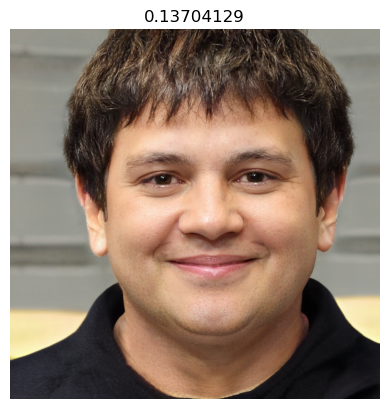

In [21]:
image_n = 0
img = generator.generate_from(np.reshape(z[image_n], (1,512)), truncation_psi=0.7)
plt.title(predictions[image_n])
plt.axis('off')
plt.imshow(img[0]/255)

In [22]:
feature_slope = find_feature_axis(z, predictions, method='tanh', n_jobs = 4)

_normalize_feature_direction = True
if _normalize_feature_direction:
    feature_direction = normalize_feature_axis(feature_slope)
else:
    feature_direction = feature_slope

with open('black_hair_feature_direction.pkl', 'wb') as f:
    pickle.dump(feature_direction, f)

fitting


In [14]:
rnd = np.random.RandomState(123)
latents = rnd.randn(9, 512)

In [15]:
feature_direction.shape

(512,)

In [16]:
imgs1 = generator.generate_from(latents, truncation_psi=0.7)
imgs2 = generator.generate_from(latents + 1.5*feature_direction, truncation_psi=0.7)

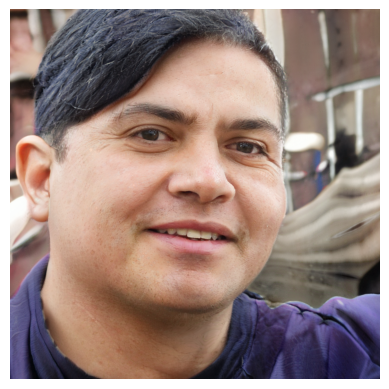

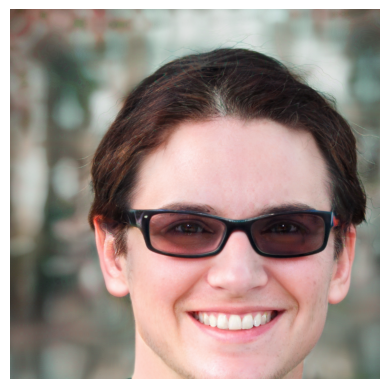

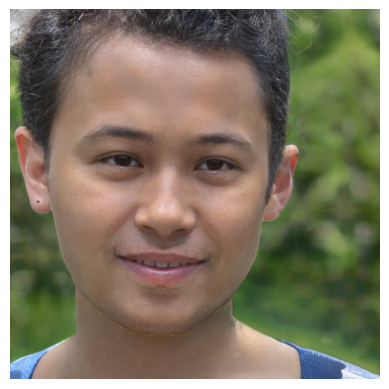

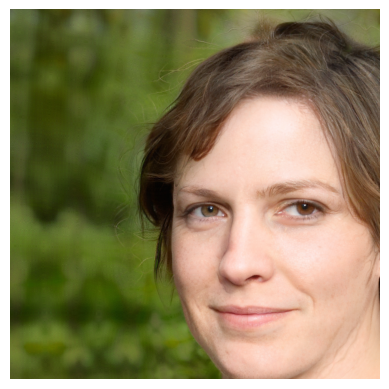

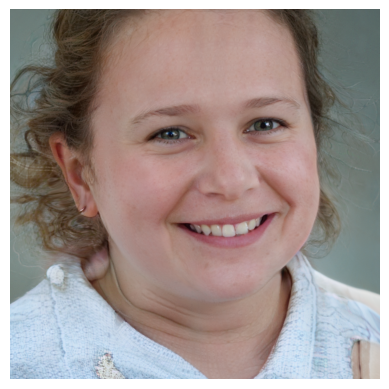

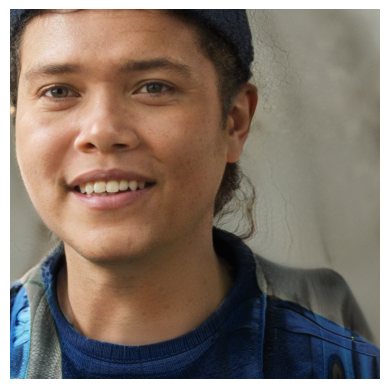

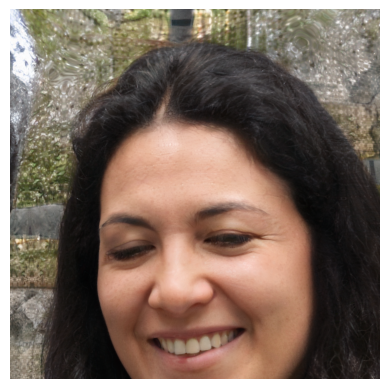

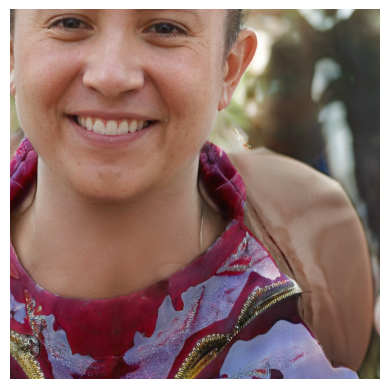

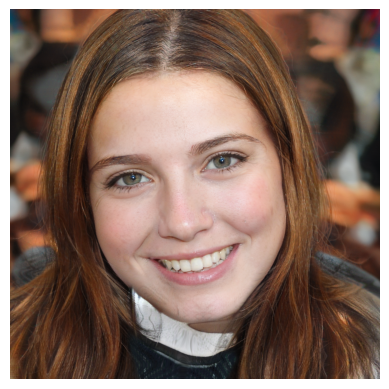

In [17]:
for img in imgs1:
    plt.axis("off")
    plt.imshow(img/255)
    plt.show()

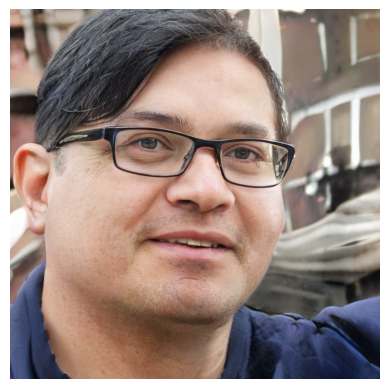

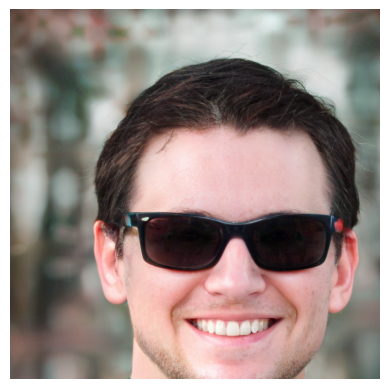

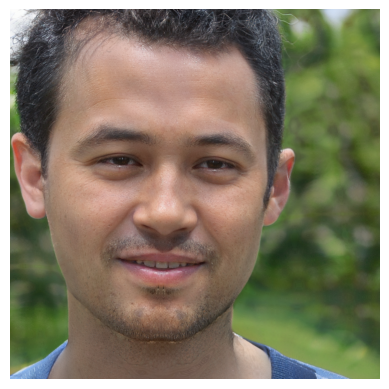

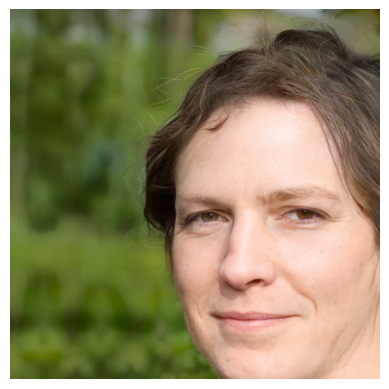

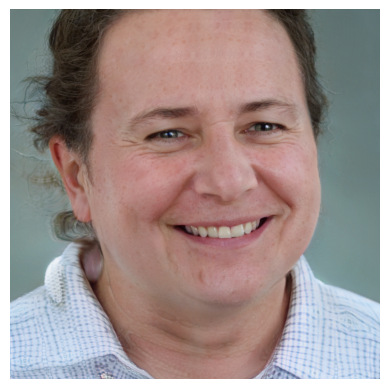

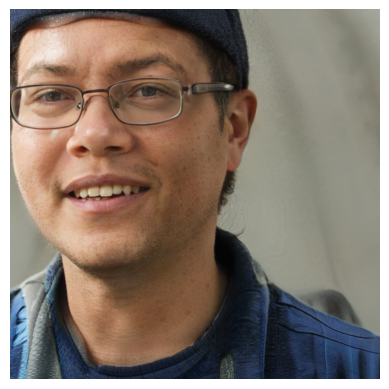

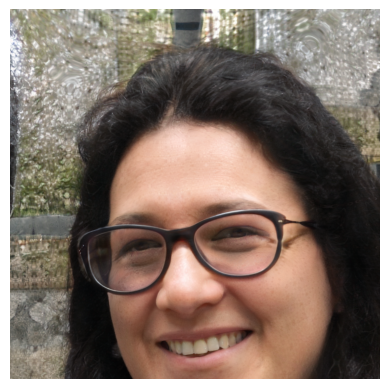

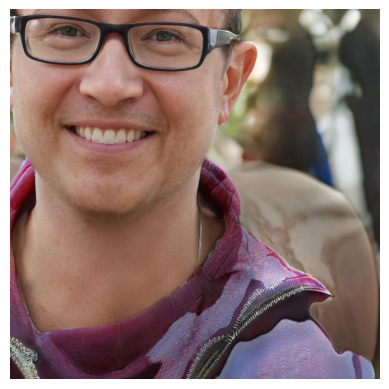

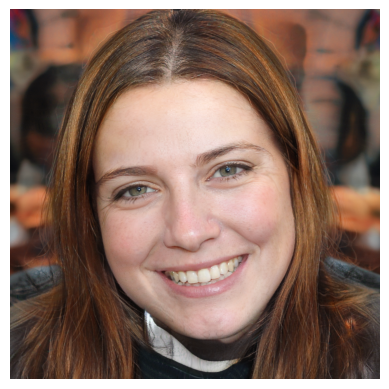

In [18]:
for img in imgs2:
    plt.axis("off")
    plt.imshow(img/255)
    plt.show()

In [59]:
predictions[predictions < 0.5].shape

(228937,)

In [61]:
no_feature_idx = np.where(predictions < 0.5)[0]
no_feature_z = z[no_feature_idx]
no_feature_predictions = predictions[no_feature_idx]

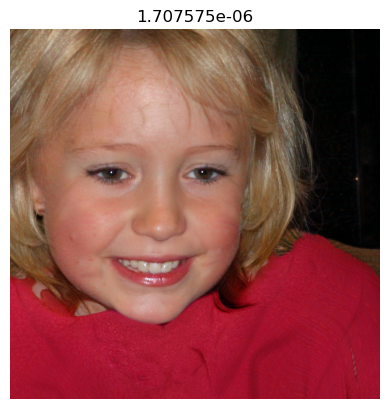

In [62]:
image_n = 1
img = generator.generate_from(np.reshape(no_feature_z[image_n], (1,512)), truncation_psi=0.7)
plt.title(no_feature_predictions[image_n])
plt.axis('off')
plt.imshow(img[0]/255)

In [63]:
feature_z = no_feature_z + 1.5*feature_direction

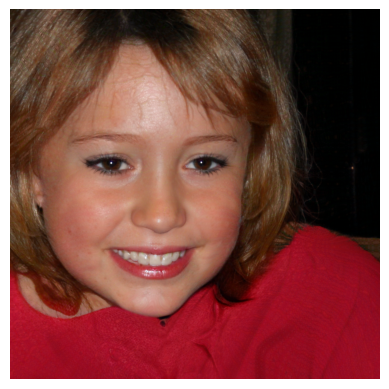

In [64]:
image_n = 1
img = generator.generate_from(np.reshape(feature_z[image_n], (1,512)), truncation_psi=0.7)
plt.axis('off')
plt.imshow(img[0]/255)

In [66]:
with h5py.File('/home/robert/data/diploma-thesis/datasets/features/z/black_hair/0.h5', 'w') as f:
    f.create_dataset('z', data=no_feature_z)

with h5py.File('/home/robert/data/diploma-thesis/datasets/features/z/black_hair/1/1_5.h5', 'w') as f:
    f.create_dataset('z', data=feature_z)